# 🌲 Getting started

## 🛠️ Installation

```
pip install pytreeclass
```

**Install development version**



```
pip install git+https://github.com/ASEM000/PyTreeClass
```

## 📖 Description

`PyTreeClass` is a JAX-compatible `dataclass`-like decorator to create and operate on stateful JAX PyTrees.
The package aims to achieve two goals:

1) 🔒 To maintain safe and correct behaviour by using _immutable_ modules with _functional_ API.
2) To achieve the **most intuitive** user experience in the `JAX` ecosystem by :
   1) 🏗️ Defining layers similar to `PyTorch` or `TensorFlow` sublcassing style.
   2) ☝️ Filtering\Indexing layer values by using boolean masking similar to `jax.numpy.at[].{get,set,apply,...}`
   3) 🎨 Visualize defined layers in plethora of ways for better debugging and sharing of information

## ⏩ Quick Example

In this example, we will demonstrate the basic features of `PyTreeClass` by constructing a simple `MLP` class.

In [1]:
import jax
import jax.random as jr 
import jax.numpy as jnp 
import pytreeclass as pytc 
import matplotlib.pyplot as plt 

In general any non `@treeclass` wrapper parameter should be defined as a dataclass field as follows:
```python
@pytc.treeclass
class Linear :
   weight : jnp.ndarray
   bias   : jnp.ndarray

   ...
```
To designate a node as non-trainable, you can use `pytreeclass.static_field(...)` in the field definition. This similar to assigning a field in dataclass using `dataclass.field(...)`

Here, let's construct a `Linear` layer with `weight` and `bias` as trainable nodes.

In [2]:
# Defininig Linear layer
@pytc.treeclass
class Linear :
   weight : jnp.ndarray
   bias   : jnp.ndarray

   def __init__(self,key,in_dim,out_dim):
       self.weight = jax.random.normal(key,shape=(in_dim, out_dim)) * jnp.sqrt(2/in_dim)
       self.bias = jnp.ones((1,out_dim))

   def __call__(self,x):
       return x @ self.weight + self.bias

Next, we will define a simple `MLP` class.
Additionally, to demonstate how can we update internal state **_immutably_**,  we will define an additional state variable `num_calls` in the `MLP` class that gets incremented with each call.

In [3]:
@pytc.treeclass
class MLP:
    layers: tuple[Linear] = ()
    num_calls : float = 0.

    def __init__(self,layers,*,key):
        keys= jax.random.split(key,len(layers)-1)
        for ki,in_dim,out_dim in zip(keys,layers[:-1],layers[1:]):
            self.layers += (Linear(key=ki,in_dim=in_dim,out_dim=out_dim),)

    def __call__(self,x):
        self.num_calls+=1
        *layers,last = self.layers
        for layer in layers:
            x = jax.nn.relu(layer(x))
        return last(x)

model = MLP([1,5,5,1],key=jr.PRNGKey(0))

Before moving forward, lets vizualize our model so far.
For visualization `PyTreeClass` implements _pretty_ `.__repr__()`, `.__str__()`, `.tree_diagram()`, and `.summary()`

- `.__repr__()` returns shorthand notation of created class.
- `.__str__()`  returns full values of created class.
- `.tree_diagram()` returns directory-tree-structure like.
- `.summary()` returns parameter name, type, count, and size.

* model shorthand representation.

In [4]:
model

MLP(
  layers=(
    Linear(weight=f32[1,5],bias=f32[1,5]),
    Linear(weight=f32[5,5],bias=f32[1,5]),
    Linear(weight=f32[5,1],bias=f32[1,1])
  ),
  num_calls=0.0
)

* model full representation.

In [5]:
print(model)

MLP(
  layers=(
    Linear(
      weight=[[-1.6248673  -2.8383057   1.3969219   1.3169124  -0.40784812]],
      bias=[[1. 1. 1. 1. 1.]]
    ),
    Linear(
      weight=
        [[ 0.0690082  -0.28695515  0.07628956 -0.0438102   0.00379491]
         [ 1.50098    -0.11166672  1.1165049  -0.04066205  0.30811653]
         [-0.7006985  -0.65002924 -0.35766158 -0.17880684 -0.6092746 ]
         [-0.03396707  0.12827015 -0.10535626  0.50696546 -0.39020923]
         [-0.1908553  -0.7502192  -1.964823   -0.02063693  0.33969834]],
      bias=[[1. 1. 1. 1. 1.]]
    ),
    Linear(
      weight=
        [[ 0.98507565]
         [ 0.99815285]
         [-1.0687716 ]
         [-0.19255024]
         [-1.2108876 ]],
      bias=[[1.]]
    )
  ),
  num_calls=0.0
)


* directory-tree-structure like.

In [6]:
print(model.tree_diagram())

MLP
    ├── layers=<class 'tuple'>
    │   ├── layers_0=Linear
    │   │   ├── weight=f32[1,5]
    │   │   └── bias=f32[1,5]   
    │   ├── layers_1=Linear
    │   │   ├── weight=f32[5,5]
    │   │   └── bias=f32[1,5]   
    │   └── layers_2=Linear
    │       ├── weight=f32[5,1]
    │       └── bias=f32[1,1]   
    └── num_calls=0.0   


* summary

In [7]:
print(model.summary())

┌───────────────┬────────────┬───────┬───────┬───────────────┐
│Name           │Type        │Param #│Size   │Config         │
├───────────────┼────────────┼───────┼───────┼───────────────┤
│layers/layers_0│tuple/Linear│10(0)  │40.00B │weight=f32[1,5]│
│               │            │       │(0.00B)│bias=f32[1,5]  │
├───────────────┼────────────┼───────┼───────┼───────────────┤
│layers/layers_1│tuple/Linear│30(0)  │120.00B│weight=f32[5,5]│
│               │            │       │(0.00B)│bias=f32[1,5]  │
├───────────────┼────────────┼───────┼───────┼───────────────┤
│layers/layers_2│tuple/Linear│6(0)   │24.00B │weight=f32[5,1]│
│               │            │       │(0.00B)│bias=f32[1,1]  │
├───────────────┼────────────┼───────┼───────┼───────────────┤
│num_calls      │float       │1(0)   │24.00B │num_calls=0.0  │
│               │            │       │(0.00B)│               │
└───────────────┴────────────┴───────┴───────┴───────────────┘
Total count :	47(0)
Dynamic count :	47(0)
Frozen count 

Let's return to training our model. First let's create some training data. 

In [8]:
x = jnp.linspace(0,1,100)[:,None]
y = x**3 + jax.random.uniform(jax.random.PRNGKey(0),(100,1))*0.01

Next, we differentiate the loss function `loss_func` with respect to model parameters by using `@jax.grad`

In [9]:
@jax.grad
def loss_func(model,x,y):
    return jnp.mean((model(x)-y)**2)

Last step is to define an update function to update the model parameters.

Note: models wrapped with `@treeclass` support unary/binary operations, therefore we can update the model simply as the following:
```python
model - learning_rate * grad
```

In [10]:
@jax.jit 
def update(model,x,y):
    jax.debug.print("{x}",x=model.num_calls)
    grad = loss_func(model,x,y)
    # let increment the number of calls by 1
    return model- 1e-3*grad

Finally, lets train for 20,000 epochs

In [11]:
for _ in range(1,20_001):
    model = update(model,x,y)

ImmutableInstanceError: Cannot set num_calls = Traced<ShapedArray(float32[], weak_type=True)>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x124e4ec30>, in_tracers=(Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/1)>,), out_tracer_refs=[<weakref at 0x125fcf1a0; to 'JaxprTracer' at 0x1265ac6d0>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { [34m[22m[1mlambda [39m[22m[22m; a[35m:f32[][39m. [34m[22m[1mlet[39m[22m[22m  [34m[22m[1min [39m[22m[22m(a,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x126566730>, name_stack=NameStack(stack=(Transform(name='jvp'),)))). Use `.at['num_calls'].set(Traced<ShapedArray(float32[], weak_type=True)>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x124e4ec30>, in_tracers=(Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/1)>,), out_tracer_refs=[<weakref at 0x125fcf1a0; to 'JaxprTracer' at 0x1265ac6d0>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { [34m[22m[1mlambda [39m[22m[22m; a[35m:f32[][39m. [34m[22m[1mlet[39m[22m[22m  [34m[22m[1min [39m[22m[22m(a,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x126566730>, name_stack=NameStack(stack=(Transform(name='jvp'),)))))` instead.

💣💣💣💣

The problem here is that model `__call__` modifies  `num_calls`  at each call, this means that the instance is not longer immutable. _This mutable behavior is not allowed in `pytreeclass`_. 

To solve this we can use `.at[...]` for functional updating the internal state as the following:
```python
...

output_value, new_model = model.at["__call__"]()

```

here the `num_calls` is updated after each model call, however to capture the updated `num_calls`  we need to return the updated instance `updated_model` along with the loss value for each loss_func call. 

Using `has_aux=True` in `jax.grad` we can output the updated_model along with the loss value.

In [12]:
import functools as ft

@ft.partial(jax.value_and_grad, has_aux=True)
def immutable_loss_func(model,x,y):
    output,updated_model= model.at["__call__"](x)
    return jnp.mean((y-output)**2), updated_model

@jax.jit
def immutable_update(model,x,y):
    (loss,updated_model),grads = immutable_loss_func(model,x,y)
    return loss, updated_model-1e-3*grads

Let's try again.

In [13]:
for i in range(1,20_001):
    loss,model = immutable_update(model,x,y)

In [14]:
print(model.num_calls)

20000.0


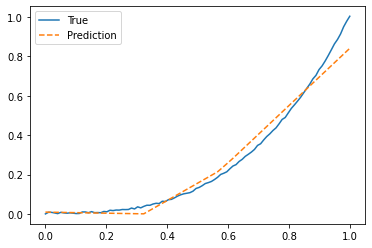

In [15]:
output,model = model.at["__call__"](x)

plt.plot(x,y, '-',label="True")
plt.plot(x,output,'--', label="Prediction")
plt.legend()

So far, we have seen how to train an immutable model in a functional way. Immutable definition and functional API is useful in mitigating bugs or unintended behavior that arises from side effects .